In [27]:
from sklearn.metrics import mean_squared_error
y_test = [0, 0, 2, 2, 4]
y_pred = [-1/3, -1/3, 7/3, 7/3, 4]
mse = mean_squared_error(y_test, y_pred)
mse

0.08888888888888893

有了新模型的残差后，便可以继续构造新的决策树来拟合残差，直到系统的均方误差 MSE 达到指定要求或者迭代次数达到指定条件时，便停止迭代，形成最终模型。因为 GBDT 算法是不停地拟合新模型的残差，所以随着新的迭代，整个系统的残差会越来越小，或者更精确的说，系统的均方误差 MSE 会越来越小，从而使得模型更加准确。

### 4. GBDT算法的简单代码实现

GBDT模型既可以做分类分析，也可以做回归分析，分别对应的模型为: **GBDT分类模型**（GradientBoostingClassifier）及 **GBDT回归模型**（GradientBoostingRegressor）。GBDT 分类模型的弱学习器是分类决策树模型，GBDT 回归模型的弱学习器是回归决策树模型。

* **GBDT 分类模型**的简单演示代码如下：

In [28]:
from sklearn.ensemble import GradientBoostingClassifier
X = [[1, 2], [3, 4], [5, 6], [7, 8], [9, 10]]
y = [0, 0, 0, 1, 1]

model = GradientBoostingClassifier(random_state=123)
model.fit(X, y)

print(model.predict([[5, 5]]))

[0]


* **GBDT回归模型**的简单演示代码如下：

In [29]:
from sklearn.ensemble import GradientBoostingRegressor
X = [[1, 2], [3, 4], [5, 6], [7, 8], [9, 10]]
y = [1, 2, 3, 4, 5]

model = GradientBoostingRegressor(random_state=123)
model.fit(X, y)

print(model.predict([[5, 5]]))

[2.54908866]


## 三、案例实战：产品定价模型

### 1. 模型搭建

首先读取1000条图书价格数据，特征变量有图书的页数，类别，彩印和纸张，目标变量是图书的定价。这里为了方便演示，只选取了4个特征变量

In [30]:
import pandas as pd
df = pd.read_csv("产品定价预测.csv")
df.head()

,页数,类别,彩印,纸张,价格,出版地,字数,出版时间,印刷数量,作者平均年龄,印张,印刷次数,版本,作者数量,月销售量,累计销售量
0,207,技术类,0,双胶纸,60,北京市,51000,2019,35000,40,26,1,2,1,610,2920
1,210,技术类,0,双胶纸,62,北京市,25000,2019,48000,51,20,4,2,4,141,410
2,206,技术类,0,双胶纸,62,北京市,88000,2019,27000,50,22,3,1,3,498,10080
3,218,技术类,0,双胶纸,64,北京市,21000,2019,20000,39,26,3,2,2,396,8760
4,209,技术类,0,双胶纸,60,北京市,28000,2019,38000,35,20,2,2,2,525,8010


通过value_counts()函数查看这1000本图书有哪些类别及各个类别对应的比例:

In [31]:
df["类别"].value_counts()

技术类    336
教辅类    333
办公类    331
Name: 类别, dtype: int64

In [32]:
df["彩印"].value_counts()

0    648
1    352
Name: 彩印, dtype: int64

In [33]:
df["纸张"].value_counts()

双胶纸    615
铜版纸    196
书写纸    189
Name: 纸张, dtype: int64

因为“类别”和“纸张”两列是分类型文本变量，因此可以采用 **LabelEncoder()函数**对分类变量进行编号，以便于后续的模型拟合:

In [34]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df["纸张"] = le.fit_transform(df["纸张"])
df["类别"] = le.fit_transform(df["类别"])
df["出版地"] = le.fit_transform(df["出版地"])
df.head()

,页数,类别,彩印,纸张,价格,出版地,字数,出版时间,印刷数量,作者平均年龄,印张,印刷次数,版本,作者数量,月销售量,累计销售量
0,207,1,0,1,60,0,51000,2019,35000,40,26,1,2,1,610,2920
1,210,1,0,1,62,0,25000,2019,48000,51,20,4,2,4,141,410
2,206,1,0,1,62,0,88000,2019,27000,50,22,3,1,3,498,10080
3,218,1,0,1,64,0,21000,2019,20000,39,26,3,2,2,396,8760
4,209,1,0,1,60,0,28000,2019,38000,35,20,2,2,2,525,8010


通过如下代码将特征变量和目标变量单独提取出来：

In [35]:
X = df.drop(columns="价格")
y = df["价格"]

提取完特征变量后需要将数据拆分为训练集及测试集。划分训练集和测试集的代码如下：

In [36]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=123)

划分为训练集和测试集之后，就可以从Scikit-Learn库中引入GBDT模型进行模型训练了，代码如下：

In [37]:
from sklearn.ensemble import GradientBoostingRegressor
model = GradientBoostingRegressor(random_state=123)
model.fit(X_train, y_train)

GradientBoostingRegressor(random_state=123)

### 2. 模型预测与评估

模型搭建完毕后，通过如下代码对测试集进行预测和评估

In [38]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

y_pred = model.predict(X_test)
score = model.score(X_test,y_test)
print("模型预测准确率=",score)

模型预测准确率= 0.8635177501230035


通过如下代码汇总预测值和实际值，以便进行对比：

In [39]:
a = pd.DataFrame()    # 创建一个空DataFrame
a["预测值"] = list(y_pred)
a["实际值"] = list(y_test)
a.head()

,预测值,实际值
0,71.690895,75
1,80.231523,84
2,69.128128,68
3,90.075714,90
4,79.885414,85


通过如下代码可以求得此时系统的均方误差 MSE

In [40]:
from sklearn.metrics import mean_squared_error
MSE = mean_squared_error(y_test, y_pred)
MSE

49.79112684272617

为了更科学合理地对产品定价，可以通过如下代码查看各个特征变量的特征重要性，以变筛选出对价格影响最大的特征变量

In [41]:
model.feature_importances_

array([0.46629718, 0.43693658, 0.04086886, 0.01509174, 0.        ,
       0.00837409, 0.        , 0.0047392 , 0.00261408, 0.00169454,
       0.00204458, 0.00048581, 0.00102289, 0.01280327, 0.00702719])

可以看到，重要性最高的是“页数”和“类别”，一般来说，页数越多的图书价格越高，技术类和办公类图书的价格略高于教辅类图书的价格。“彩印”和“纸张”的重要性较低，对图书价格的影响较小。

基于决策树的算法都可以输出特征的重要度，其中sklearn中GBDT的特征重要度函数为feature_importances_，lightgbm中的特征重要度函数为feature_importance，这里以sklearn中的GBDT为例，输出特征重要度：

   feature_name  importance
0            页数    0.466297
1            类别    0.436937
2            彩印    0.040869
3            纸张    0.015092
13         月销售量    0.012803
5            字数    0.008374
14        累计销售量    0.007027
7          印刷数量    0.004739
8        作者平均年龄    0.002614
10         印刷次数    0.002045
9            印张    0.001695
12         作者数量    0.001023
11           版本    0.000486
4           出版地    0.000000
6          出版时间    0.000000


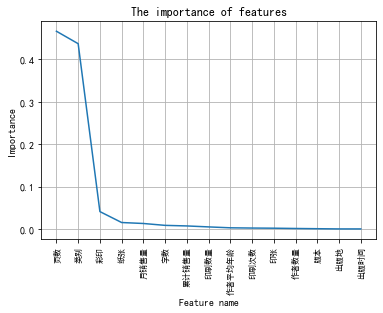

In [42]:
import matplotlib.pyplot as plt
plt.rcParams["font.sans-serif"] = ["SimHei"]   # 用来正常显示中文标签
plt.rcParams["axes.unicode_minus"] = False     # 解决负号"-"显示为方块的问题

def plot_feature_importance(dataset, model_bst):
    list_feature_name = list(dataset.columns[:])
    # list_feature_importance = list(model_bst.feature_importance(importance_type='split', iteration=-1))
    list_feature_importance = list(model_bst.feature_importances_)
    dataframe_feature_importance = pd.DataFrame(
        {'feature_name': list_feature_name, 'importance': list_feature_importance})
    dataframe_feature_importance20 = dataframe_feature_importance.sort_values(by='importance', ascending=False)[:20]
    print(dataframe_feature_importance20)
    x = range(len(dataframe_feature_importance20['feature_name']))
    plt.xticks(x, dataframe_feature_importance20['feature_name'], rotation=90, fontsize=8)
    plt.plot(x, dataframe_feature_importance20['importance'])
    plt.xlabel("Feature name")
    plt.ylabel("Importance")
    plt.title("The importance of features")
    plt.grid()
    plt.show()
    
import matplotlib.pyplot as plt
plt.rcParams["font.sans-serif"] = ["SimHei"]   # 用来正常显示中文标签
plt.rcParams["axes.unicode_minus"] = False     # 解决负号"-"显示为方块的问题

plot_feature_importance(X_train,model)

### 3. GDBT 模型参数调优

前面搭建的 GDBT 模型使用的是默认参数，其预测效果已经很不错了，如果进行参数调优，先来了解该模型的参数。在 Jupyter Notebook 中，可以输入并运行如下代码来查看官方文档

In [43]:
from sklearn.ensemble import GradientBoostingRegressor
#GradientBoostingRegressor?

|参数|含义|取值|
|:---:|:---:|:---:|
|loss|损失函数|取值为'ls'代表均方差损失函数，取值为'lad'代表绝对损失函数，取值为'huber'代表Huber损失函数，取值为'quantile'代表分位数损失函数，默认取均方差损失函数'ls'|
|learning_rate|弱学习器的权重缩减系数ν|取值范围为(0,1]，默认取0.1|
|n_estimators|弱学习器的最大迭代次数|取值为int型数据，默认取100|
|subsample|子采样比率|为了防止GBDT模型发生过拟合建立每棵回归树时采用子采样，该参数取值范围为(0,1]；取值为1代表在建立回归树时使用所有样本，取值小于1代表通过不放回抽样使用部分样本；默认取1|
|criterion|特征选择标准|取值为string型，默认为'friedman_mse'。'friedman_mse'是费尔德曼均方误差，'mse'是均方误差，'mae'是平均绝对误差|
|min_samples_split|分割内部节点所需要的最小样本数量|取值为int型或者float型。如果为整数，那么该值为最小样本数量；如果为浮点型，这是一个百分比。默认为2|
|min_samples_leaf|叶子节点上的最小样本数量|取值为int型或者float型。如果为整数，那么该值为最小样本数量；如果为浮点型，这是一个百分比，默认为1|
|min_weight_fraction_leaf|叶子节点最小的样本权重和|默认取0，即不考虑权重问题，如果小于该数值，该叶子节点会和兄弟节点一起被剪枝（即剔除该叶子节点和其兄弟节点，并停止分裂）。如果较多样本有缺失值或者样本的分布类别偏差很大，则需考虑样本权重问题。|
|max_depth|最大深度|取值为int型，最大深度限制了树的节点数，默认为3|
|min_impurity_decrease|分裂节点阈值|如果节点的分裂导致不纯度的下降大于或等于该参数，则分裂该节点，浮点型，默认为0|
|min_impurity_split|停止树生长的阈值|如果节点的不纯度高于阈值，就进行分裂，否则就是叶子节点；取值为float型，默认为1e-7|
|random_state|设定随机状态|取值范围为：{int整数, RandomState实例, None}。如果为整数，则指定了随机数生成器的种子，设置为任意整数后，例如“123”，则每次运行的结果都是一致的；如果为RandomState实例，则指定了随机数生成器；如果为None，则使用默认的随机数生成器。默认为None|
|max_features|寻找最佳切割时要考虑的特征数量|int型，float型，string型或者None，如果为int型，代表要考虑的特征数量；如果为float型，即百分比；如果为'auto'，代表sqrt(n_features)；如果为'sqrt'，和'auto'一样；如果为'log2'，代表log2(n_features)；如果为None,代表n_features；默认取'None'|
|verbose|控制输出|整数型，默认为0，如果为0则不输出日志，如果为1，则每隔一段时间输出日志，大于1输出日志会更频繁|
|max_leaf_nodes|最大叶子节点数|取值为int型数据，默认为None|
|warm_start|热启动|布尔型，设置为True时，重用前一个调用的解决方案以适合初始化，否则只擦除前一个解决方案，默认为False|
|presort|数据预排序|指定是否需要提前对数据进行排序从而加速寻找最优切分点。设置为True时，在数据量大时会减慢总体的训练过程，但对于小数据集或者设定了最大深度的情况下，则会加速训练过程|
|validation_fraction|留作早期停止的验证集训练数据的比例|float型，默认为0.1|
|n_iter_no_change|确定当验证分数没有提高时是否提前停止训练|取值为int型，默认为None。取值为None时，禁止提前停止训练；取值为整数时，将保留'validation_fraction'的数据用作验证，并在验证得分在之前'n_iter_no_change_'轮迭代中没有提高时终止训练|
|tol|提前停止训练的条件|取值为float型，默认为1e-4。损失改善小于tol时，训练停止|

* **（1）网格搜索（GridSearchCV）**

首先我们从步长(learning rate)和迭代次数(n_estimators)入手。一般来说，开始选择一个较小的步长来网格搜索最好的迭代次数。这里，我们将步长初始值设置为0.1。对于迭代次数进行网格搜索如下：

In [18]:
from sklearn.model_selection import GridSearchCV
parameters = {"n_estimators":[20,30,40,50,60,80], "learning_rate":[0.05, 0.1, 0.2, 0.3,0.5,1]}
model =  GradientBoostingRegressor()
grid_search = GridSearchCV(model, parameters,  cv=5)
grid_search.fit(X,y)     # 传入数据
grid_search.best_params_             # 输出参数的最优值

{'learning_rate': 0.3, 'n_estimators': 80}

In [19]:
from sklearn.ensemble import GradientBoostingRegressor
model2 = GradientBoostingRegressor(n_estimators=80,learning_rate=0.3)
model2.fit(X_train, y_train)

score = model2.score(X_test,y_test)
print("模型预测准确率=",score)

模型预测准确率= 0.8697811585550834


* **（2）贝叶斯优化器（bayesian  optimization)**

python用户可以采用下方命令行可以快速的安装贝叶斯调试利器—— bayesian-optimization

pip install -i https://mirrors.aliyun.com/pypi/simple bayesian-optimization

贝叶斯优化器需要定义好贝叶斯调参的目标函数，以及参数空间的范围。运行gbdt_op.maximize()，就可以开始用贝叶斯优化去搜索最优参数空间了

In [44]:
from sklearn.model_selection import cross_val_score
from bayes_opt import BayesianOptimization
def gbdt_cv(n_estimators, min_samples_split, max_features, max_depth):
    res = cross_val_score( 
        GradientBoostingRegressor(n_estimators=int(n_estimators),
                                                        min_samples_split=int(min_samples_split),
                                                        max_features=min(max_features, 0.999), # float
                                                        max_depth=int(max_depth),
                                                        random_state=2
        ),
        X_train, y_train, cv=20
    ).mean()
    return res

gbdt_op = BayesianOptimization(
        gbdt_cv,
        {'n_estimators': (10, 250),
        'min_samples_split': (2, 25),
        'max_features': (0.1, 0.999),
        'max_depth': (5, 15)}
    )

gbdt_op.maximize()

ImportError: cannot import name 'just_fix_windows_console' from 'colorama' (C:\ProgramData\Anaconda3\lib\site-packages\colorama\__init__.py)

In [ ]:
print(gbdt_op.max)

上方是调参过程，我们可以看到，各参数空间所对应的得分，以及每个参数空间的具体数值情况。把相应最优参数代入GBDT回归模型，然后对模型进行训练和评估

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
model3 = GradientBoostingRegressor(n_estimators=48,min_samples_split=25,
                                  max_features=0.999,max_depth=5)
model3.fit(X_train, y_train)

score = model3.score(X_test,y_test)
print("模型预测准确率=",score)

# 学习曲线

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['font.sans-serif'] = ['SimHei'] # 指定默认字体
plt.rcParams['axes.unicode_minus']=False    #解决负数坐标显示问题
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import numpy as np
def plot_learning_curves(model, X,y):
    X_train, X_val, y_train, y_val = train_test_split(X,y, test_size=0.2)
    train_errors, val_errors = [], []
    for m in range(1, len(X_train)):
        model.fit(X_train[:m], y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_val_predict = model.predict(X_val)
        train_errors.append(mean_squared_error(y_train_predict, y_train[:m]))
        val_errors.append(mean_squared_error(y_val_predict, y_val))
    plt.plot(np.sqrt(train_errors), "r-+", linewidth=2, label="train")
    plt.plot(np.sqrt(val_errors),"b-",linewidth=3, label="val")
    
lin_reg =GradientBoostingRegressor(n_estimators=48,min_samples_split=25,
                                  max_features=0.999,max_depth=5)
plot_learning_curves(lin_reg, X, y)
plt.grid()
plt.legend()
plt.title("学习曲线")
X.shape, y.shape

# AdaBoost

In [ ]:
from sklearn.ensemble import AdaBoostRegressor
clf =AdaBoostRegressor(random_state=123)
clf.fit(X_train,y_train)

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

y_pred = clf.predict(X_test)
score = clf.score(X_test,y_test)
print("模型预测准确率=",score)

In [ ]:
a = pd.DataFrame()    # 创建一个空DataFrame
a["预测值"] = list(y_pred)
a["实际值"] = list(y_test)
a.head()

In [ ]:
from sklearn.metrics import mean_squared_error
MSE = mean_squared_error(y_test, y_pred)
MSE

In [ ]:
clf.feature_importances_

In [ ]:
from sklearn.model_selection import GridSearchCV
parameters = {"n_estimators":[20,30,40,50,60,80], "learning_rate":[0.05, 0.1, 0.2, 0.3,0.5,1]}
model = AdaBoostRegressor()
grid_search = GridSearchCV(model, parameters,  cv=5)
grid_search.fit(X,y)     # 传入数据
grid_search.best_params_             # 输出参数的最优值

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
model2 = AdaBoostRegressor(n_estimators=80,learning_rate=1)
model2.fit(X_train, y_train)

score = model2.score(X_test,y_test)
print("模型预测准确率=",score)

In [ ]:
from sklearn.model_selection import cross_val_score
from bayes_opt import BayesianOptimization
def gbdt_cv(n_estimators):
    res = cross_val_score( 
        AdaBoostRegressor(n_estimators=int(n_estimators), random_state=2
        ),
        X_train, y_train, cv=20
    ).mean()
    return res

gbdt_op = BayesianOptimization(
        gbdt_cv,
        {'n_estimators': (10, 250),
       }
    )

gbdt_op.maximize()

In [ ]:
print(gbdt_op.max)

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
model3 = AdaBoostRegressor(n_estimators=10,learning_rate=1)
model3.fit(X_train, y_train)

score = model3.score(X_test,y_test)
print("模型预测准确率=",score)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['font.sans-serif'] = ['SimHei'] # 指定默认字体
plt.rcParams['axes.unicode_minus']=False    #解决负数坐标显示问题
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import numpy as np
def plot_learning_curves(model, X,y):
    X_train, X_val, y_train, y_val = train_test_split(X,y, test_size=0.2)
    train_errors, val_errors = [], []
    for m in range(1, len(X_train)):
        model.fit(X_train[:m], y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_val_predict = model.predict(X_val)
        train_errors.append(mean_squared_error(y_train_predict, y_train[:m]))
        val_errors.append(mean_squared_error(y_val_predict, y_val))
    plt.plot(np.sqrt(train_errors), "r-+", linewidth=2, label="train")
    plt.plot(np.sqrt(val_errors),"b-",linewidth=3, label="val")
    
lin_reg =AdaBoostRegressor(n_estimators=10,learning_rate=1)
plot_learning_curves(lin_reg, X, y)
plt.grid()
plt.legend()
plt.title("学习曲线")
X.shape, y.shape